In [1]:
import asyncio
from dotenv import load_dotenv

load_dotenv()
import nest_asyncio
import aiohttp

nest_asyncio.apply()
from openai import AsyncOpenAI
import json
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

In [2]:
# Load json from data/data.json

with open("data/data.json") as f:
    data = json.load(f)
print(data["pictures"])

[{'description': 'An animated question mark', 'timestamp': 0}, {'description': 'A colorful, simplified diagram of a trie data structure', 'timestamp': 3}, {'description': 'An animated tree sprouting arrays as leaves', 'timestamp': 6}, {'description': 'A stopwatch ticking', 'timestamp': 12}, {'description': 'A book rapidly flipping pages, then zooming into a smartphone screen', 'timestamp': 15}, {'description': 'A smiling face with sunglasses', 'timestamp': 20}]


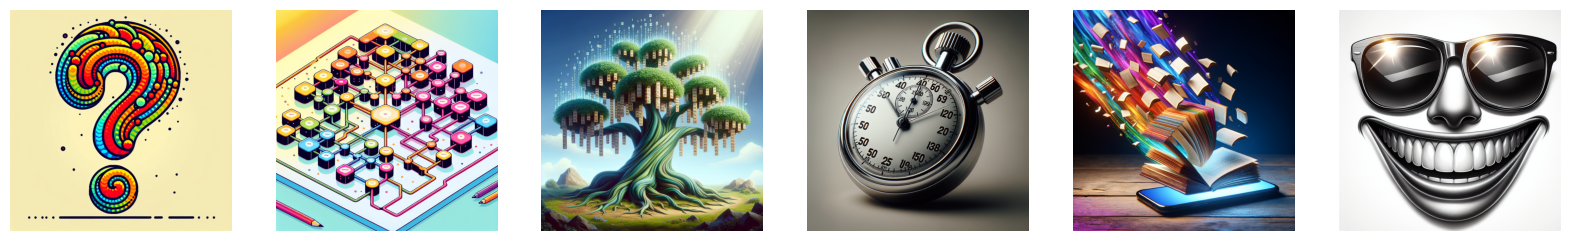

In [3]:
client = AsyncOpenAI()


async def fetch_image_binary(url):
    async with aiohttp.ClientSession() as session:
        async with session.get(url) as response:
            # Make sure the request was successful
            if response.status == 200:
                # Read and return the binary content of the image
                return await response.read()
            else:
                # Handle possible HTTP errors (e.g., 404 Not Found) here if needed
                return None


async def generate_image(description):
    response = await client.images.generate(
        model="dall-e-3",
        prompt=description,
        size="1024x1024",
        quality="standard",
        n=1,
    )
    image_binary = await fetch_image_binary(response.data[0].url)
    return image_binary


async def generate_images(pictures):
    tasks = [generate_image(picture['description']) for picture in pictures]
    imgs = await asyncio.gather(*tasks)
    return imgs

imgs = asyncio.run(generate_images(data["pictures"]))

# Set up the matplotlib figure and axes
fig, axes = plt.subplots(1, len(imgs), figsize=(20, 5))  # Adjust figsize as needed

for ax, img in zip(axes, imgs):
    image = Image.open(BytesIO(img))
    ax.imshow(image)
    ax.axis("off")  # Hide axes ticks

plt.show()

In [4]:
# Save each img in to data/images folder
for i, img in enumerate(imgs):
    with open(f"data/images/image_{i}.png", "wb") as f:
        f.write(img)